In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import time 
import seaborn as sns
import re
import json
import shapely.geometry as sg
from rank_bm25 import BM25Okapi
import geopandas as gpd
from shapely.geometry import Point
from rapidfuzz import process
#from fuzzywuzzy import process

# Data cleaning

In [2]:
df = pd.read_csv('sale_lands_29_10_2023.csv')

/tmp/ipykernel_7013/1626953326.py:1: DtypeWarning: Columns (9,14,16,17,18,22,23,32) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('sale_lands_29_10_2023.csv')


In [3]:
len(df)

144810

In [4]:
#import bentoml 
#loaded_model_apartment_rant = bentoml.lightgbm.load_model("rant_lightgbm_40-85:latest")

In [5]:
#import lightgbm as lgb

# Assuming loaded_model_land is your trained LightGBM model (Booster object)
#loaded_model_apartment_rant.save_model('loaded_model_apartment_rant.txt')

In [6]:
#bentoml.import_bento('lightgbm_sals_rant_test-ioot4uec26atgasc.bento')

In [7]:
df['prdx_desc'] = df['prdx_desc'].astype(str)

# Keep only the anouces after 2018
df['year'] = df['prdx_created_at'].astype(str).str.slice(0,4).astype(int)
df = df[df['year'] >= 2019]

In [8]:
df.drop(columns=['anc_price_type', 'prdx_accept_exchange','prdx_equipments',
       'prdx_price_preview', 'prdx_view_number', 'prdx_likes_number','pieces', 'etages', 
       'property_payment_conditions','asset_in_promotional_site', 'sale_by_real_estate_agent', 'adr_id',
       'adr_checked','adr_distance_from_city', 'adr_distance_from_state',
       'adr_distance_to_sea', 'adr_filled_from_matching', 'cty_id','cty_2008_population', 'cty_area', 'cty_longitude', 'cty_latitude',
       'stt_id', 'stt_ouedkniss_id', 'adr_address_02', 'prdx_ouedkniss_id',], inplace=True)

In [9]:
# drop the agricol lands
df = df[~(df['type']=='terrain_agricole')]

In [10]:
df['prdx_created_on_ouedkniss_at']

0         2023-02-05 23:22:40
1         2023-02-05 22:48:17
2         2023-02-05 22:38:03
3         2023-02-05 22:37:58
4         2023-02-05 22:36:27
                 ...         
144805    2023-09-13 21:48:30
144806    2023-09-13 21:24:48
144807    2023-09-13 22:00:26
144808    2023-09-13 22:01:11
144809    2023-09-13 22:06:39
Name: prdx_created_on_ouedkniss_at, Length: 131348, dtype: object

In [11]:
df['prdx_created_on_ouedkniss_at'] = df['prdx_created_on_ouedkniss_at'].str.split(' ').str[0]

In [12]:
df['prdx_created_on_ouedkniss_at'] = pd.to_datetime(df['prdx_created_on_ouedkniss_at'])

In [13]:
from datetime import datetime, timedelta

# Get the current date or the last date from your dataset
current_date = df['prdx_created_on_ouedkniss_at'].max()

# Calculate the date 4 months ago
four_months_ago = current_date - pd.DateOffset(months=4)

# Filter the dataset into two parts
last_four_months_data = df[df['prdx_created_on_ouedkniss_at'] >= four_months_ago]
other_data = df[df['prdx_created_on_ouedkniss_at'] < four_months_ago]

In [14]:
words_to_drop = ['FERTILE', 'agricol','فلاحية'] 

# Create a boolean mask for rows containing the words to drop
mask = df['prdx_desc'].str.contains('|'.join(words_to_drop), case=False, na=False)

# Use the mask to filter and drop the rows
df = df[~mask]


In [15]:
df.reset_index(drop=True,inplace=True)

In [16]:
df['prdx_desc'] = df["prdx_desc"].astype(str)

## Clean superficie column

In [17]:
def extract_largest_area_refined(description):
    try:
        # Initialize variables
        largest_area = 0

        # If the description is not a string, return 0
        if not isinstance(description, str):
            return 0

        # Replace newline and carriage return characters
        description = description.replace('\n', ' ').replace('\r', ' ').strip()

        # Define regular expression patterns to find area in various formats
        area_patterns = [
            r'(\d{1,3}(?:[.,]\d{3})*(?:[.,]\d{0,2})?)\s*m[²2]',  # Fixed pattern
            r'(\d+[\.,]?\d*)\s*sqm',    # 200 sqm
            r'(\d+[\.,]?\d*)\s*²',      # 175²
            r'(\d+[\.,]?\d*)\s*m[èeé]tres?\s*au\s*carr[éeé]',  # 152 metres au carre
            r'(\d+[\.,]?\d*)\s*m[èeé]tres?\s*carr[éeés]',      # 120 metre carrés, 155metre carré
            r'قدرها\s*(\d+[\.,]?\d*)\s*متر',  # مساحة قدرها 385 متر
            r'\s*(\d+[\.,]?\d*)\s*متر²',
            r'\s*(\d+[\.,]?\d*)\s*مترًا مربعًا',
            r'\s*(\d+[\.,]?\d*)\s*متر مربع',
            r'\s*(\d+[\.,]?\d*)\s*م مربع',
            r'\s*(\d+[\.,]?\d*)\s*م²',  # المساحة الكلية : 190 م²
            r'\s*(\d+[\.,]?\d*)\s*م2',
            r'مساحة\s*(\d+[\.,]?\d*)',  #
        ]

        # Search for all area matches
        for pattern in area_patterns:
            area_matches = re.findall(pattern, description, re.IGNORECASE)
            for area_match in area_matches:
                # Adjust the conversion to treat dots as thousand separators
                area = float(area_match.replace(',', '.').replace('.', ''))
                largest_area = max(largest_area, area)

        return largest_area
    except Exception as e:
        return np.nan

# Apply the extract_area function to create a new column
df['size'] = df['prdx_desc'].apply(extract_largest_area_refined)



In [18]:
# Use regular expressions to extract the numeric part before the string

def process_superficie(value):
    try:
        # Attempt to convert the value to an integer
        return float(value)
    except ValueError:
        # If it can't be converted, apply the custom function
        match = re.search(r'\d+', value)
        if match:
            return float(match.group())
        else:
            return 0  

df['size'] = df['size'].apply(process_superficie) 
df['superficie'] = df['superficie'].apply(process_superficie)
# Fill missing values in "superficie" with values from the new column
# Replace values in 'superficie_extracted' that are missing, zero, or smaller than 80 with values from 'zise'
df['superficie'] = df.apply(lambda row: row['size'] if (row['superficie'] is None or row['superficie'] == 0 or row['superficie'] < 80) else row['superficie'], axis=1)
#df['superficie'].fillna(df['size'], inplace=True)
df['superficie'] = df['superficie'].astype(float)        

In [19]:
df.drop(columns=['size'],inplace = True)

In [20]:
extract_largest_area_refined("""Ø¨ÙØ¹ ÙØ·Ø¹Ø© Ø§Ø±Ø¶ ÙÙ Ø­ÙØ§Ø¯Ù Ø­Ù ØµÙØ§ÙØ¯ÙØ©
ÙØ±ÙØ¨ ÙÙ Ø·Ø±ÙÙ Ø§ÙØ³ÙØ§Ø±Ø© Ø¨ÙØ³Ø§Ø­Ø© 150
Ø·ÙÙ 20
Ø§ÙØ¹Ø±Ø¶ 7.5
ÙØ§Ø¬ÙØ© ÙØ§Ø­Ø¯Ø©""")

/home/zaki/Desktop/H/beytic/lib/python3.10/site-packages/IPython/core/inputtransformer2.py:627: UserWarning: `make_tokens_by_line` received a list of lines which do not have lineending markers ('\n', '\r', '\r\n', '\x0b', '\x0c'), behavior will be unspecified
  tokens_by_line = make_tokens_by_line(lines)


0

## Clean the price column

In [21]:
def final_refined_extract_price(description):
    try:
        # Initialize variables
        highest_custom_price = 0
        found_price = False  # Flag to indicate if any price information was found

        # If the description is not a string, return 0
        if not isinstance(description, str):
            return 0

        # Replace newline and carriage return characters
        description = description.replace('\n', ' ').replace('\r', ' ').strip()

        # Define regular expression patterns
        milliards_pattern = r'(\d+[\.,]?\d*)?\s*(milliards?|ملايير|مليار|ملير|miliard)\s*(\d+[\.,]?\d*)?'
        millions_pattern = r'(\d+[\.,]?\d*)\s*(millions?|مليون|millient|milion)\s*(\d+[\.,]?\d*)?\s*(DA|د ج|دج)?'
        
        # Modified unit_pattern to ensure it matches with '/m' and not just 'm'
        unit_pattern = r'((?:\d{1,3}(?:[\.\s])?)*\d{1,3}(?:[\.,]\d{2})?)[\s,.]*(u/m|u|ung|unités|/m)(?![a-zA-Z])'
        
        # Modified regular_price_pattern
        regular_price_pattern = r'((?:\d{1,3}[\.\s]?)*\d{1,3})\s*(DA|د ج|دج)(?![a-zA-Z])'
        
        # Modified Prix_pattern to include negative lookahead for 'm', 'mètres' without any following spaces
        Prix_pattern = r'(?:Prix:?\s+)(?:de\s+)*((?:\d{1,3}[\.\s,]?)*\d{1,3}(?:[\.,]\d{2})?)(?!\s*(millions?|milliards?|مليون|ملايير|مليار|ملير|miliard|u|DA|د ج|دج|[mM](?!\s)|mètres))'
        
        # Search for the "Prix" patterns
        Prix_matches = re.findall(Prix_pattern, description, re.IGNORECASE)
        for Prix_match in Prix_matches:
            found_price = True
            captured_price = Prix_match[0].replace('.', '').replace(' ', '').replace(',', '.')
            custom_price = int(float(captured_price))
            highest_custom_price = max(highest_custom_price, custom_price)
        
        # Search for all milliards matches
        milliards_matches = re.findall(milliards_pattern, description, re.IGNORECASE)
        for milliards_match in milliards_matches:
            milliards_before = milliards_match[0]
            milliards_after = milliards_match[2]
            if milliards_before or milliards_after:
                found_price = True  # Found some price information
                milliards = 1 if not milliards_before else float(milliards_before.replace(',', '.').replace(' ', ''))
                millions = 0 if not milliards_after else float(milliards_after.replace(',', '.').replace(' ', ''))
                custom_price = int(milliards * 10**7) + int(millions * 10**4)
                highest_custom_price = max(highest_custom_price, custom_price)

        # Search for all millions matches
        millions_matches = re.findall(millions_pattern, description, re.IGNORECASE)
        for millions_match in millions_matches:
            found_price = True  # Found some price information
            millions = float(millions_match[0].replace(',', '.').replace(' ', ''))
            thousands = 0 if not millions_match[2] else float(millions_match[2].replace(',', '.').replace(' ', ''))
            custom_price = int(millions * 10**4) + int(thousands * 10**1)  # Convert the thousands part correctly
            highest_custom_price = max(highest_custom_price, custom_price)

        # Search for unit patterns
        unit_matches = re.findall(unit_pattern, description, re.IGNORECASE)
        for unit_match in unit_matches:
            found_price = True
            units = unit_match[0].replace(' ', '')
            # Handle the European-style number formatting (28.000,00)
            if '.' in units and ',' in units:
                units = units.replace('.', '').replace(',', '.')
            units = float(units)
            # Check if the pattern is 'u' or 'u/m' and multiply units by 10^4
            if unit_match[1].lower() in ('u', 'u/m',"/m"):
                units *= 10**4
            custom_price = int(units)
            highest_custom_price = max(highest_custom_price, custom_price)

        # Search for the regular price patterns
        regular_matches = re.findall(regular_price_pattern, description, re.IGNORECASE)
        for regular_match in regular_matches:
            found_price = True  # Found some price information
            captured_price = regular_match[0].split(',')[0]  # Removing the part after the comma
            captured_price = captured_price.replace('.', '').replace(' ', '')  # Removing dots and spaces
            if ',' in regular_match[0]: 
                captured_price = str(int(captured_price)*100 + int(regular_match[0].split(',')[1]))
            elif regular_match[1]:  # If 'DA' was present but not a comma
                captured_price = captured_price
            else:
                captured_price = str(int(captured_price) * 10)
            custom_price = int(captured_price)
            highest_custom_price = max(highest_custom_price, custom_price)

        # If no price information was found, return 0
        if not found_price:
            return 0

        return highest_custom_price
    except Exception as e:
        return 0



In [22]:
final_refined_extract_price("""A vendre terrain agricole
A 5 km de djelida 
Superficie : 6 hectares et 15 ares
Acte notarié , Livret foncier
prix offert   2 milliards 850 millions """)

28500000

In [23]:
final_refined_extract_price("""facede prix 55ung """)

55

In [24]:
len(df)

127441

In [25]:
df.isna().sum()

Unnamed: 0                          0
prdx_id                             0
prdx_name                       90634
prdx_desc                           0
prdx_created_at                     0
prdx_created_on_ouedkniss_at     2099
prdx_price                      30840
prdx_price_unit                 21148
type                                0
superficie                       3428
property_specifications         16802
papers                          97618
adr_address_01                   6774
adr_longitude                    9303
adr_latitude                     9303
cty_name                            0
stt_name                            0
clean_address                    9802
address_request_id               9802
year                                0
dtype: int64

In [26]:
df['price'] = df["prdx_desc"].apply(final_refined_extract_price)

# Replace values in 'prdx_price' based on specified conditions
"""df['prdx_price'] = df.apply(
    lambda row: row['price'] 
    if (row['prdx_price'] in {1, 1000, 0,10000} 
        or pd.isna(row['prdx_price']) 
        or row['prdx_price'] <= 0 
        or row['prdx_price'].astype(str).str.len() <= 3
        or str(row['prdx_price']).startswith('1234') 
        or str(row['prdx_price']).startswith('111')) 
    else row['prdx_price'], 
    axis=1)"""

df['prdx_price'] = df.apply(
    lambda row: row['price'] 
    if (
        row['prdx_price'] in {1, 1000, 0, 10000,100000} or 
        pd.isna(row['prdx_price']) or 
        row['prdx_price'] <= 0 or 
        len([digit for digit in str(int(row['prdx_price'])) if digit != '0']) > 3 or
        len(str(row['prdx_price'])) <= 3 or
        str(row['prdx_price']).startswith('1234') or 
        str(row['prdx_price']).startswith('111')
    ) 
    else row['prdx_price'], 
    axis=1)



# drop all the rows where prdx_price is 0
df = df[df['prdx_price'] != 0]   

# drop all rowa where superficie is nan or less then 100
df = df[~((df['superficie'] < 80) | (pd.isna(df['superficie'])))]

## Clean the addresses

In [27]:
gmap_2 = pd.read_csv('gmap_addresses_lands.csv',usecols=['request_id','query','data_7','coordinate'])

In [28]:
# Function to compute BM25 ranking and return the most similar document's text

def get_most_similar_text_bm25(query, documents):
    # Ensure all documents are strings
    documents = [str(doc) for doc in documents]

    # Tokenize the documents
    tokenized_docs = [doc.split(" ") for doc in documents]
    bm25 = BM25Okapi(tokenized_docs)
    
    # Tokenize the query
    tokenized_query = query.split(" ")
    
    # Get scores for the query against the documents
    doc_scores = bm25.get_scores(tokenized_query)
    
    # Get the index of the highest score
    most_similar_doc_index = np.argmax(doc_scores)
    
    # Return the actual document text that is the best match
    return documents[most_similar_doc_index]


# Assume df is already defined and has the columns 'clean_address' and 'address_request_id'
# Also assume that gmap_2 is defined and has the columns 'request_id', 'data_7', and 'coordinate'

# Add a 'geo' and 'best match' column to df
df['geo'] = None
df['best match'] = None
df['adr_address_01'] = df['adr_address_01'].astype(str)
df['cty_name'] =df['cty_name'].astype(str)
df['stt_name'] = df['stt_name'].astype(str)

# Iterate over df


for idx, row in df.iterrows():
    match = row['adr_address_01'] + ', ' + row['cty_name'] + ', ' + row['stt_name']
    if (match is None) or pd.isna(row['address_request_id']):
        df.at[idx, 'geo'] = np.nan
        continue
    
    filtered_gmap_2 = gmap_2[gmap_2['request_id'] == row['address_request_id']]
    
    if len(filtered_gmap_2) == 1:
        df.at[idx, 'geo'] = filtered_gmap_2['coordinate'].iloc[0]
    elif len(filtered_gmap_2) > 1:
        most_similar_text = get_most_similar_text_bm25(match, filtered_gmap_2['data_7'].tolist())
        matching_rows = filtered_gmap_2[filtered_gmap_2['data_7'] == most_similar_text]
        
        # Check if there is at least one matching row
        if not matching_rows.empty:
            match_row = matching_rows.iloc[0]
            df.at[idx, 'geo'] = match_row['coordinate']
            df.at[idx, 'best match'] = most_similar_text
        else:
            # Handle the case where no matching row is found
            df.at[idx, 'geo'] = np.nan
            df.at[idx, 'best match'] = "No match found"

## Drop the wrong locations

In [29]:


# Load the data (that contains the geometry)
ii = pd.read_csv('final_commune_with_prices_10_28.csv')

# Convert the geometry column of ii to actual geometry objects
ii = gpd.GeoDataFrame(ii, geometry=gpd.GeoSeries.from_wkt(ii['geometry']))

def process_row(row):
    # Fuzzy match on stt_name using rapidfuzz
    matched_state = process.extractOne(row['stt_name'].lower(), ii['stt_name'].str.lower().unique(), score_cutoff=80)
    if not matched_state:
        return True

    state_filtered = ii[ii['stt_name'].str.lower() == matched_state[0].lower()]

    # Fuzzy match on cty_name using rapidfuzz
    matched_city = process.extractOne(row['cty_name'].lower(), state_filtered['commune_name'].str.lower(), score_cutoff=80)
    if not matched_city:
        return True

    city_row = state_filtered[state_filtered['commune_name'].str.lower() == matched_city[0].lower()].iloc[0]

    # Check if the point falls within the polygon
    point = Point(row['adr_longitude'], row['adr_latitude'])
    if point.within(city_row['geometry']):
        return True
    else:
        return False

# Apply the function to each row in iiiii
mask = df.apply(process_row, axis=1)
df = df[mask]

In [30]:
df['cty_name']=df['cty_name'].str.replace('gue de constantine',"djasr kasentina", case=False)
df['cty_name']=df['cty_name'].str.replace('ain naadja',"djasr kasentina", case=False)
df['cty_name']=df['cty_name'].str.replace("Said hamdine",'bir Mourad Rais', case=False)
df['cty_name']=df['cty_name'].str.replace("Chevalley",'bouzareah', case=False)
df['cty_name']=df['cty_name'].str.replace("bologhine",'bulughin', case=False)
df['cty_name']=df['cty_name'].str.replace("mahelma",'mehalma', case=False)
df['cty_name']=df['cty_name'].str.replace("é","e", case=False)
df['cty_name'] = df['cty_name'].str.replace("barrahel","berrahal", case=False)
df['cty_name'] = df['cty_name'].str.replace("mezghrane","Mazagran", case=False)
df['cty_name'] = df['cty_name'].str.replace("tassaft ouguemoun","Iboudraren", case=False)
df['cty_name'] = df['cty_name'].str.replace("kemir oued adjoul","kheiri oued adjoul", case=False)
df['cty_name'] = df['cty_name'].str.replace("Les eucalyptus","eucalyptus", case=False)
df['cty_name'] = df['cty_name'].str.replace("Sidi mhamed","sidi m'hamed", case=False)
df['cty_name'] = df['cty_name'].str.replace("Hraoua","Heraoua", case=False)

## SPLIT THE df to better clean the prices 

In [31]:
# Creating df_1 (that contains prices that are price/squar_meter)

mask_1 = (df['stt_name'] == 'Algiers') & (df['prdx_price'] > 30000) & (df['prdx_price'] < 500000)

mask_2 = (df['stt_name'] != 'Algiers') & \
         df['stt_name'].isin(['Oran', 'Boumerdes', 'Blida', 'Tipaza', 'Tizi ouzou', 'Annaba', 
                              'Constantine', 'Bejaia', 'Setif', 'Sidi bel abbes','Jijel']) & \
         (df['prdx_price'] > 10000) & (df['prdx_price'] < 450000)

mask_3 = (df['stt_name'] != 'Algiers') & \
         ~df['stt_name'].isin(['Oran', 'Boumerdes', 'Blida', 'Tipaza', 'Tizi ouzou', 'Annaba', 
                               'Constantine', 'Bejaia', 'Setif', 'Sidi bel abbes','Jijel']) & \
         (df['prdx_price'] > 5000) & (df['prdx_price'] < 250000)

df_1 = pd.concat([df[mask_1], df[mask_2],df[mask_3]])

# Invert masks (find elements that do NOT satisfy any of the conditions for df_1)
inverse_mask = ~(mask_1 | mask_2 | mask_3)

# Place the rest of the elements in df_2 (with the full prices)
df_2 = df[inverse_mask]

In [32]:
# Create 'price_per_meter' column  (for df_2 only)

df_2['price_per_meter'] = df_2['prdx_price'] / df_2['superficie']

# Define the bounds for each stt_name group
bounds = {
    'default': {'upper': 250000, 'lower': 5000},
    'Algiers': {'upper': 700000, 'lower': 25000},
    'specific_cities': {
        'names': [
            'oran', 'boumerdes', 'blida', 'tipaza', 'tizi ouzou', 'annaba', 
            'constantine', 'bejaia', 'setif', 'sidi bel abbes','Jijel'
        ],
        'upper': 450000,
        'lower': 8000
    }
}

def adjust_value_limited(row):
    #Adjust the price_per_meter value based on the rules provided, with limited iterations.
    stt = row['stt_name'].lower()
    
    # Determine the bounds for the current row
    if stt == 'algiers':
        upper_bound = bounds['Algiers']['upper']
        lower_bound = bounds['Algiers']['lower']
    elif stt in bounds['specific_cities']['names']:
        upper_bound = bounds['specific_cities']['upper']
        lower_bound = bounds['specific_cities']['lower']
    else:
        upper_bound = bounds['default']['upper']
        lower_bound = bounds['default']['lower']

    # Adjust the value with a maximum of 10 iterations to prevent infinite loops
    val = row['price_per_meter']
    original_val = val
    iterations = 0
    max_iterations = 10000000
    while ((val > upper_bound) or (val < lower_bound)) and iterations < max_iterations:
        if val > upper_bound:
            val /= 10
        elif val < lower_bound:
            val *= 10

        # If value shifts from one boundary to the other, mark for deletion
        if (original_val > upper_bound and val < lower_bound) or (original_val < lower_bound and val > upper_bound):
            return None

        iterations += 1

    return val

# Apply the function to adjust values
df_2['price_per_meter'] = df_2.apply(adjust_value_limited, axis=1)

# Remove rows with None values in 'price_per_meter'
df_2 = df_2.dropna(subset=['price_per_meter'])

# Remove rows with 'superficie' value of 0
#price_df = price_df[price_df['superficie'] != 0]

# Filter out any rows with NaN or inf values in 'price_per_meter'
df_2 = df_2[np.isfinite(df_2['price_per_meter'])]

# Round the values in 'price_per_meter' to the nearest integer
df_2['price_per_meter'] = df_2['price_per_meter'].round(0).astype(int)

/tmp/ipykernel_7013/1122647192.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2['price_per_meter'] = df_2['prdx_price'] / df_2['superficie']
/tmp/ipykernel_7013/1122647192.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2['price_per_meter'] = df_2.apply(adjust_value_limited, axis=1)


## Fill the 'price_per_meter' for df_1

In [33]:
df_1['price_per_meter'] = df_1['prdx_price']

### create a new column for df_1, df_2 to know witch transformation has been applyed to them

In [34]:
df_1['operation'] = 1
df_2['operation'] = 2

In [35]:
df_1.reset_index(drop=True, inplace=True)
df_2.reset_index(drop=True, inplace=True)

In [36]:
# creat a new df to concat the two df_1 and df_2 

df_3 = pd.concat([df_1, df_2])
df_3 = df_3[['adr_latitude','adr_longitude','stt_name','cty_name','prdx_price','price_per_meter','price','operation','prdx_id', 'superficie','adr_address_01','address_request_id']]
df_3.reset_index(drop=True,inplace=True)

In [37]:
df_3

,adr_latitude,adr_longitude,stt_name,cty_name,prdx_price,price_per_meter,price,operation,prdx_id,superficie,adr_address_01,address_request_id
0,36.767152,2.973181,Algiers,Cheraga,1.650000e+05,165000.0,0,1,63,640.0,Zouaoua,NaN
1,36.785017,3.011942,Algiers,Bouzareah,8.000000e+04,80000.0,80000,1,567,969.0,Les deux piliers.,NaN
2,NaN,NaN,Algiers,djasr kasentina,1.200000e+05,120000.0,0,1,2037,200.0,Sefsafa,NaN
3,36.771637,3.313548,Algiers,Heraoua,1.700000e+05,170000.0,95000,1,2288,1700.0,hraoua,NaN
4,36.713446,3.211632,Algiers,Dar el beida,2.600000e+05,260000.0,260000,1,2384,480.0,centre,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
64038,36.673819,3.260890,Boumerdes,Hammedi,6.750000e+06,45000.0,0,2,1799375,150.0,خلف غرفة التبريد ، مقابل مصنع زيما حي مغلق,2.023103e+13
64039,36.703247,3.024264,Algiers,Saoula,1.540000e+02,100000.0,0,2,1799376,154.0,Ville,2.023103e+13
64040,36.263749,2.203953,Ain defla,Khemis miliana,2.500000e+07,70028.0,0,2,1799391,357.0,محمد حلايمي,2.023103e+13
64041,36.713548,4.047307,Tizi ouzou,Tizi ouzou,1.920000e+09,160000.0,160000,2,1799400,12000.0,Tizi ouzou,2.023103e+13


In [38]:
len(df_3)

64043

## Apply log transformation to the price_per_meter 

In [39]:
# log transformation of prices 
df_3['log_price_per_meter'] = np.log1p(df_3['price_per_meter'])

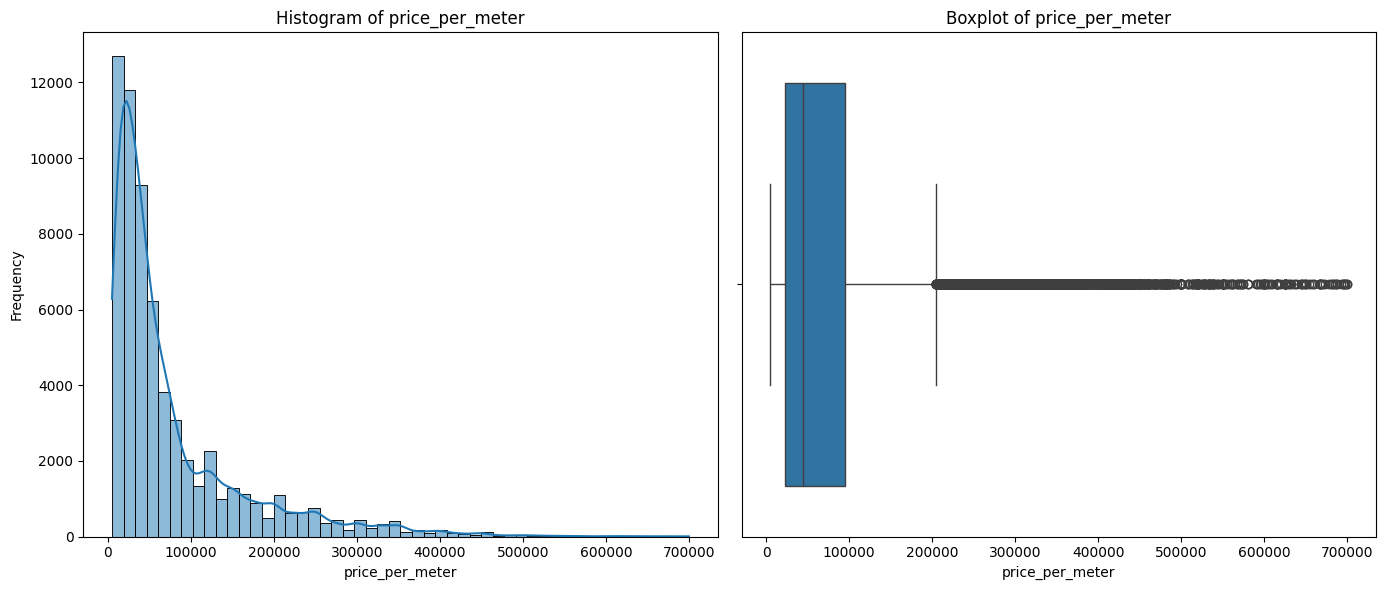

In [40]:
# Set up the figure and axes
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plot a histogram
sns.histplot(df_3['price_per_meter'], bins=50, kde=True, ax=ax[0])
ax[0].set_title('Histogram of price_per_meter')
ax[0].set_xlabel('price_per_meter')
ax[0].set_ylabel('Frequency')

# Plot a box plot
sns.boxplot(x=df_3['price_per_meter'], ax=ax[1])
ax[1].set_title('Boxplot of price_per_meter')
ax[1].set_xlabel('price_per_meter')

plt.tight_layout()
plt.show()

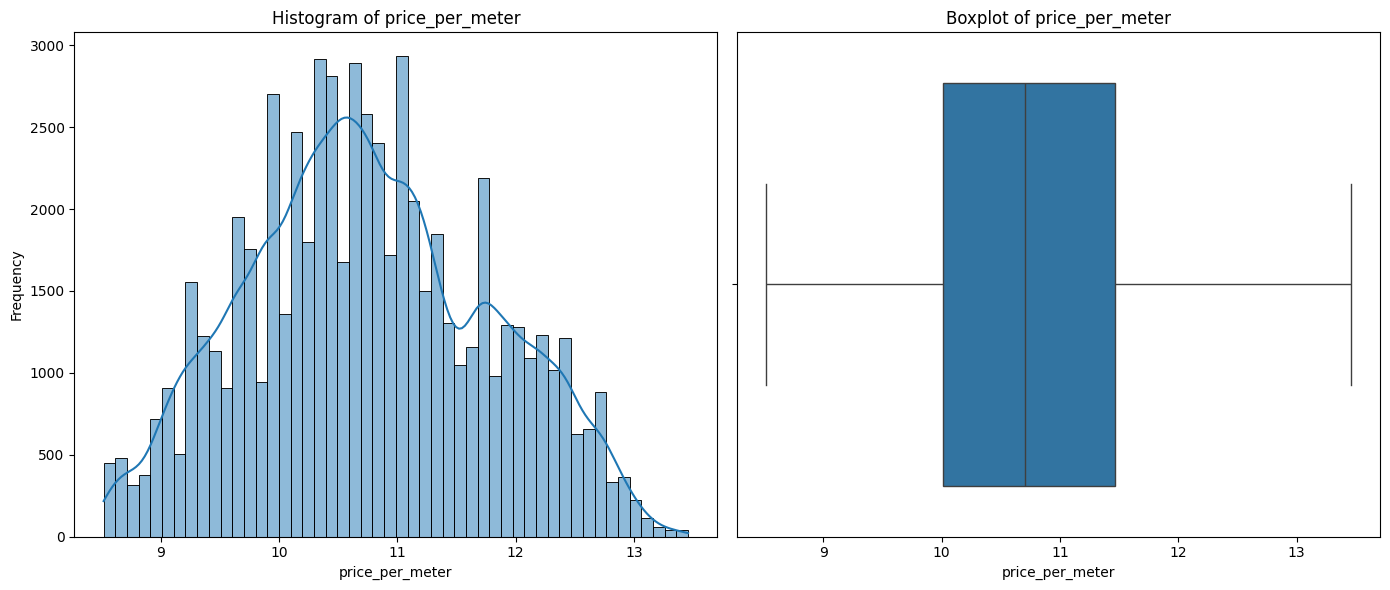

In [41]:
# Set up the figure and axes
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plot a histogram
sns.histplot(df_3['log_price_per_meter'], bins=50, kde=True, ax=ax[0])
ax[0].set_title('Histogram of price_per_meter')
ax[0].set_xlabel('price_per_meter')
ax[0].set_ylabel('Frequency')

# Plot a box plot
sns.boxplot(x=df_3['log_price_per_meter'], ax=ax[1])
ax[1].set_title('Boxplot of price_per_meter')
ax[1].set_xlabel('price_per_meter')

plt.tight_layout()
plt.show()

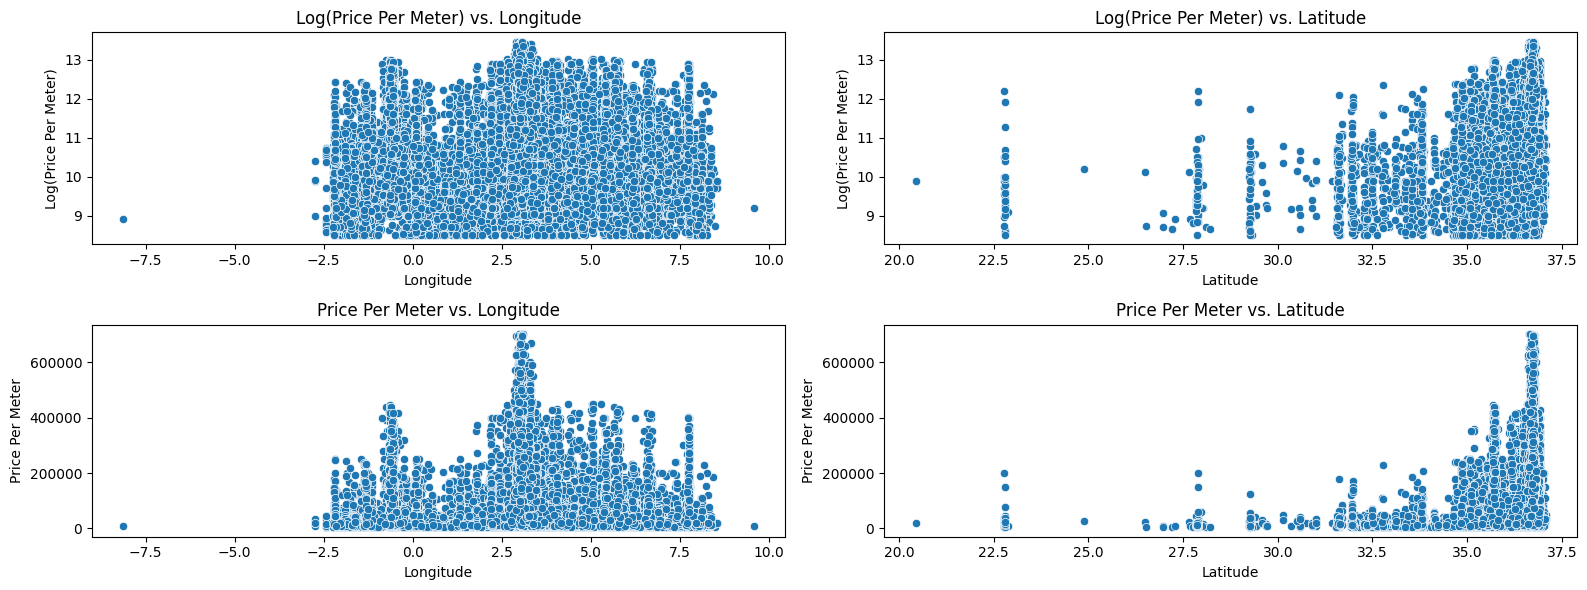

,adr_longitude,adr_latitude,log_price_per_meter,price_per_meter
adr_longitude,1.000000,0.359528,0.021098,-0.006002
adr_latitude,0.359528,1.000000,0.295468,0.212955
log_price_per_meter,0.021098,0.295468,1.000000,0.862804
price_per_meter,-0.006002,0.212955,0.862804,1.000000


In [42]:
# Setting up the visualization
fig, ax = plt.subplots(2, 2, figsize=(16, 6))

# Scatter plot for adr_longitude vs. log_price_per_meter
sns.scatterplot(x='adr_longitude', y='log_price_per_meter', data=df_3, ax=ax[0, 0])
ax[0, 0].set_title('Log(Price Per Meter) vs. Longitude')
ax[0, 0].set_xlabel('Longitude')
ax[0, 0].set_ylabel('Log(Price Per Meter)')

# Scatter plot for adr_latitude vs. log_price_per_meter
sns.scatterplot(x='adr_latitude', y='log_price_per_meter', data=df_3, ax=ax[0, 1])
ax[0, 1].set_title('Log(Price Per Meter) vs. Latitude')
ax[0, 1].set_xlabel('Latitude')
ax[0, 1].set_ylabel('Log(Price Per Meter)')

# Scatter plot for adr_longitude vs. price_per_meter
sns.scatterplot(x='adr_longitude', y='price_per_meter', data=df_3, ax=ax[1, 0])
ax[1, 0].set_title('Price Per Meter vs. Longitude')
ax[1, 0].set_xlabel('Longitude')
ax[1, 0].set_ylabel('Price Per Meter')

# Scatter plot for adr_latitude vs. price_per_meter
sns.scatterplot(x='adr_latitude', y='price_per_meter', data=df_3, ax=ax[1, 1])
ax[1, 1].set_title('Price Per Meter vs. Latitude')
ax[1, 1].set_xlabel('Latitude')
ax[1, 1].set_ylabel('Price Per Meter')

plt.tight_layout()
plt.show()

# Calculating the correlation coefficients
correlations = df_3[['adr_longitude', 'adr_latitude', 'log_price_per_meter', 'price_per_meter']].corr()

correlations



In [43]:
s = df_3.copy()

### Clean the prices

In [44]:
# Load the datasets

cty_bounds_data = pd.read_excel('cty_bounds.ods')

# Ensuring consistent format for 'cty_name'
s['cty_name'] = s['cty_name'].str.strip().str.lower()
cty_bounds_data['cty_name'] = cty_bounds_data['cty_name'].str.strip().str.lower()

# Merging the dataframes on 'cty_name'
merged_data = pd.merge(s, cty_bounds_data, on='cty_name', how='left')

# Updating the function to calculate bounds
def calculate_bounds(row):
    if pd.isna(row['lower_bound']) or pd.isna(row['upper_bound']):
        median = merged_data[merged_data['cty_name'].str.lower() == row['cty_name'].lower()]['price_per_meter'].median()
        if median < 100000:
            lower = max(median - 20000, 25000) if row['cty_name'].lower() == 'algiers' else max(median - 10000, 6000)
            upper = median + 100000
        elif 100000 <= median < 200000:
            lower = median - 40000
            upper = median + 150000
        elif 200000 <= median < 300000:
            lower = median - 40000
            upper = median + 250000
        elif 300000 <= median < 400000:
            lower = median - 40000
            upper = median + 250000
    else:
        lower = row['lower_bound']
        upper = row['upper_bound']
    return pd.Series({'lower_bound': lower, 'upper_bound': upper})

# Applying the function to calculate bounds
calculated_bounds = merged_data.apply(calculate_bounds, axis=1)
merged_data.update(calculated_bounds)

# Identifying Outliers
merged_data['out'] = ((merged_data['price_per_meter'] < merged_data['lower_bound']) | 
                      (merged_data['price_per_meter'] > merged_data['upper_bound'])).astype(int)

# Correcting Outliers - Part 1
def correct_outliers(row):
    if row['out'] == 1 and row['lower_bound'] <= row['price'] <= row['upper_bound']:
        row['price_per_meter'] = row['price']
        row['out'] = 0
    return row
s = merged_data.apply(correct_outliers, axis=1)

# Correcting Outliers - Part 2
def adjust_value(value, lower, upper):
    original_value = value
    max_iterations = 10000  
    iterations = 0
    while value < lower and value <= original_value and iterations < max_iterations:
        value *= 10
        iterations += 1
    iterations = 0
    while value > upper and value >= original_value and iterations < max_iterations:
        value /= 10
        iterations += 1
    return value if lower <= value <= upper else original_value

def correct_outliers_2(row):
    if row['out'] == 1:
        if row['operation'] == 1:
            new_val = adjust_value(row['price_per_meter'], row['lower_bound'], row['upper_bound'])
            if not (row['lower_bound'] <= new_val <= row['upper_bound']):
                new_val = row['price'] / row['superficie']
                new_val = adjust_value(new_val, row['lower_bound'], row['upper_bound'])
        elif row['operation'] == 2:
            new_val = adjust_value(row['price_per_meter'], row['lower_bound'], row['upper_bound'])
            if not (row['lower_bound'] <= new_val <= row['upper_bound']):
                new_val = adjust_value(row['prdx_price'], row['lower_bound'], row['upper_bound'])
        if row['lower_bound'] <= new_val <= row['upper_bound']:
            row['price_per_meter'] = new_val
            row['out'] = 0
    return row
df_4 = s.apply(correct_outliers_2, axis=1)

In [45]:
### Drop rows where 'adr_latitude','adr_longitude','price_per_meter' are  nan

In [46]:
df_4=  df_4.dropna(subset=['adr_latitude','adr_longitude','price_per_meter'])

In [47]:
#df_2 = df_2 [(df_2['price_per_meter'] <= 340000)]

def modified_drop_outliers(group):
    unique_prices = group['price_per_meter'].nunique()
    
    # If the group has only one or two unique 'price_per_meter' values, keep all records
    if unique_prices <= 2:
        return group
    
    Q1 = group['price_per_meter'].quantile(0.50)
    Q3 = group['price_per_meter'].quantile(0.95)
    lower_bound = Q1
    upper_bound = Q3
    
    return group[(group['price_per_meter'] >= lower_bound) & (group['price_per_meter'] <= upper_bound)]

# Apply the modified function to each group and concatenate the results
df_4 = df_4.groupby(['adr_latitude', 'adr_longitude']).apply(modified_drop_outliers).reset_index(drop=True)

# Check the number of unique groups after applying the modified function
len(df_4.groupby(['adr_latitude', 'adr_longitude']).size().reset_index(name='count'))

10024

# Create data points 

### Load impot prices for each commmune,  with  it's geometry

In [48]:
final_villages_df = pd.read_csv('vent/vent_terrain_with_places_3.csv')

## Create data  points for communes where we have less than 5 points

In [49]:
import numpy as np
import pandas as pd
import geopandas as gpd
import shapely
from shapely.wkt import loads
from shapely.geometry import Point, Polygon, MultiPolygon
from fuzzywuzzy import process,fuzz

def convert_to_geometry(data):
    try:
        return shapely.wkt.loads(data)
    except Exception as e:
        # Return an empty Point geometry if conversion fails
        return shapely.geometry.Point()


def filter_uuuuu_by_stt_name(stt_name, df, threshold=80):
    unique_stt_names = df['stt_name'].str.lower().unique()
    matches = process.extract(stt_name.lower(), unique_stt_names, scorer=fuzz.WRatio, limit=None)
    
    # Filter matches that meet the threshold
    valid_matches = [match for match, score in matches if score >= threshold]
    
    if valid_matches:
        best_match = valid_matches[0]  # Choose the best match (the one with the highest score)
        return df[df['stt_name'].str.lower() == best_match.lower()]
    else:
        return pd.DataFrame()


def calculate_rapports(row):
    centre_mean = (row['centre_min'] + row['centre_max']) / 2
    peripherique_mean = (row['peripherique_min'] + row['peripherique_max']) / 2
    far_mean = (row['far_min'] + row['far_max']) / 2

    rapport_centre_min = row['centre_min'] / centre_mean if (not np.isnan(row['centre_min']) and centre_mean != 0) else np.nan
    rapport_centre_max = row['centre_max'] / centre_mean if (not np.isnan(row['centre_max']) and centre_mean != 0) else np.nan
    rapport_peripherique_min = row['peripherique_min'] / peripherique_mean if (not np.isnan(row['peripherique_min']) and peripherique_mean != 0) else np.nan
    rapport_peripherique_max = row['peripherique_max'] / peripherique_mean if (not np.isnan(row['peripherique_max']) and peripherique_mean != 0) else np.nan
    rapport_far_min = row['far_min'] / far_mean if (not np.isnan(row['far_min']) and far_mean != 0) else np.nan
    rapport_far_max = row['far_max'] / far_mean if (not np.isnan(row['far_max']) and far_mean != 0) else np.nan

    return pd.Series({
        'rapport_centre_min': rapport_centre_min,
        'rapport_centre_max': rapport_centre_max,
        'rapport_peripherique_min': rapport_peripherique_min,
        'rapport_peripherique_max': rapport_peripherique_max,
        'rapport_far_min': rapport_far_min,
        'rapport_far_max': rapport_far_max
    })



def generate_random_points_within_polygon(polygon, num_points=5):
    if polygon.is_empty:
        print("Skipped empty polygon.")
        return []
    
    minx, miny, maxx, maxy = polygon.bounds
    points = []
    
    while len(points) < num_points:
        random_point = Point(np.random.uniform(minx, maxx), np.random.uniform(miny, maxy))
        if random_point.within(polygon):
            points.append(random_point)
    
    return points

def correct_invalid_geometry(geometry):
    """Corrects an invalid geometry using a buffer trick."""
    if not geometry.is_valid:
        return geometry.buffer(0)
    return geometry

def handle_nan_values(row):
    # Fallback logic for NaN values
    if np.isnan(row['far_min']) or np.isnan(row['far_max']):
        if np.isnan(row['peripherique_min']) or np.isnan(row['peripherique_max']):
            row['far_min'] = row['centre_min']
            row['far_max'] = row['centre_max']
        else:
            row['far_min'] = row['peripherique_min']
            row['far_max'] = row['peripherique_max']
    return row

def generate_and_append_points_with_price(geometry, stt_name, commune_name, min_price, max_price, data_list):
    points = generate_random_points_within_polygon(geometry)
    for point in points:
        random_price = np.random.uniform(min_price, max_price) if not np.isnan(min_price) and not np.isnan(max_price) else np.nan
        data_list.append({
            'stt_name': stt_name,
            'commune_name': commune_name,
            'latitude': point.y,
            'longitude': point.x,
            'price': random_price
        })

def generate_points_with_pricing_logic(row, stt_name, commune_name, mean_price, rapports, data_list):
    if not np.isnan(mean_price):
        # For center
        generate_and_append_points_with_price(row['center'], stt_name, commune_name, 
                                              mean_price * rapports['rapport_centre_min'], mean_price * rapports['rapport_centre_max'], data_list)
        
        # For peripherique
        peripherique_geometry = correct_invalid_geometry(row['peripherique']).difference(correct_invalid_geometry(row['center']))
        generate_and_append_points_with_price(peripherique_geometry, stt_name, commune_name, 
                                              mean_price * rapports['rapport_peripherique_min'], mean_price * rapports['rapport_peripherique_max'], data_list)
        
        # For far
        far_geometry = correct_invalid_geometry(row['geometry']).difference(correct_invalid_geometry(row['peripherique']))
        generate_and_append_points_with_price(far_geometry, stt_name, commune_name, 
                                              mean_price * rapports['rapport_far_min'], mean_price * rapports['rapport_far_max'], data_list)
    else:
        # Use specified min and max values when mean_price is NaN
        generate_and_append_points_with_price(row['center'], stt_name, commune_name, 
                                              row['centre_min'], row['centre_max'], data_list)
        
        peripherique_geometry = correct_invalid_geometry(row['peripherique']).difference(correct_invalid_geometry(row['center']))
        generate_and_append_points_with_price(peripherique_geometry, stt_name, commune_name, 
                                              row['peripherique_min'], row['peripherique_max'], data_list)
        
        far_geometry = correct_invalid_geometry(row['geometry']).difference(correct_invalid_geometry(row['peripherique']))
        generate_and_append_points_with_price(far_geometry, stt_name, commune_name, 
                                              row['far_min'], row['far_max'], data_list)

# Assuming final_villages_df, s (uuuuu DataFrame) are already defined
# New logic begins here
# New logic begins here
final_villages_df['geometry'] = final_villages_df['geometry'].apply(convert_to_geometry)
final_villages_df['center'] = final_villages_df['center'].apply(convert_to_geometry)
final_villages_df['peripherique'] = final_villages_df['peripherique'].apply(convert_to_geometry)

generated_points_data = []

for stt_name in final_villages_df['stt_name'].str.lower().unique():
    # Filter data_df using fuzzy search for stt_name
    filtered_data_df = filter_uuuuu_by_stt_name(stt_name.lower(), df_4)  # Assuming s is defined and is the data_df

    # Filter reference_df for the current stt_name
    filtered_reference_df = final_villages_df[final_villages_df['stt_name'].str.lower() == stt_name.lower()]

    for _, row in filtered_reference_df.iterrows():
        commune_name = row['commune_name']  # Assuming 'commune_name' is the column name in reference_df

        if not filtered_data_df.empty:
            # Check if commune_name is in the filtered data_df
            if commune_name.lower() in filtered_data_df['cty_name'].str.lower().values:
                if len(filtered_data_df[filtered_data_df['cty_name'].str.lower() == commune_name.lower()]) <= 5:
                    mean_price = filtered_data_df['price_per_meter'].mean() if commune_name in filtered_data_df['cty_name'].values else np.nan
                    rapports = calculate_rapports(row)
                    generate_points_with_pricing_logic(row, stt_name, commune_name, mean_price, rapports, generated_points_data)
                else:
                    # Skip if count is more than 5
                    pass
            else:
                # If commune_name is not in cty_name
                row = handle_nan_values(row)
                generate_points_with_pricing_logic(row, stt_name, commune_name, np.nan, None, generated_points_data)
        else:
            # If filtered_data_df is empty (stt_name not in s)
            row = handle_nan_values(row)
            generate_points_with_pricing_logic(row, stt_name, commune_name, np.nan, None, generated_points_data)

generated_points_df = pd.DataFrame(generated_points_data)


/home/zaki/Desktop/H/beytic/lib/python3.10/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


Skipped empty polygon.


### Drop rows where price is nan

In [50]:
generated_points_df.dropna(inplace=True)

In [51]:
# rename and reorgnize columns
generated_points_df.columns = generated_points_df.columns.str.replace('commune_name', 'cty_name')
generated_points_df.columns = generated_points_df.columns.str.replace('latitude', 'adr_latitude')
generated_points_df.columns = generated_points_df.columns.str.replace('longitude', 'adr_longitude')
generated_points_df.columns = generated_points_df.columns.str.replace('price', 'price_per_meter')
generated_points_df = generated_points_df[['cty_name', 'adr_latitude', 'adr_longitude', 'stt_name','price_per_meter']]

### keep  only the  needed columns 

In [52]:
df_4 = df_4[['cty_name', 'adr_latitude', 'adr_longitude', 'stt_name','price_per_meter']]

# Train the model

## Split the data and concat the generated_points_df with X_train (try adding it to df_4)

In [53]:
from sklearn.model_selection import train_test_split

single_occurrence_cities = df_4['cty_name'].value_counts()[df_4['cty_name'].value_counts() == 1].index

# Filter out rows with those city names and store them separately
single_occurrence_data = df_4[df_4['cty_name'].isin(single_occurrence_cities)]
df_4 = df_4[~df_4['cty_name'].isin(single_occurrence_cities)]

# Splitting the remaining data into training and testing sets using 'cty_name' for stratification
X = df_4.drop(columns=['price_per_meter'])
y = df_4['price_per_meter']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=X['cty_name'], random_state=42, shuffle=True)


# Add single-occurrence data to the training data
X_train = pd.concat([X_train, single_occurrence_data.drop(columns=['price_per_meter'])], ignore_index=True)
y_train = pd.concat([y_train, single_occurrence_data['price_per_meter']], ignore_index=True)

X_train = pd.concat([X_train, generated_points_df.drop(columns=['price_per_meter'])], ignore_index=True)
y_train = pd.concat([y_train, generated_points_df['price_per_meter']], ignore_index=True)
# Create X_test_algiers and y_test_algiers


X_train = X_train.drop(columns=['cty_name'])
X_test = X_test.drop(columns=['cty_name'])
X_train = X_train.drop(columns=['stt_name'])
X_test = X_test.drop(columns=['stt_name'])

## train the model (whit hyperparameter tunning and experimentation tracking)

In [57]:
len(df_4)

34703

In [58]:

print(mlflow.get_tracking_uri())

file:///home/zaki/Desktop/H/mlruns


In [69]:
import optuna
import mlflow
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import cross_val_score

# Check if the 'sales_apartments' experiment exists, if not create it

experiment_name = 'sales_lands'
experiment = mlflow.get_experiment_by_name(experiment_name)
if experiment is None:
    mlflow.create_experiment(experiment_name)

#mlflow.set_tracking_uri(uri="file:///home/zaki/Desktop/H/mlruns")
# Set the experiment to the one we're working on
mlflow.set_experiment(experiment_name)


def objective(trial):
    param = {
        'boosting_type': 'gbdt',
        'objective': 'regression',
        'metric': 'rmse',
        'learning_rate': trial.suggest_float('learning_rate', 0.1, 0.3, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 350, 500),
        'max_depth': trial.suggest_int('max_depth', 15, 22),
        'num_leaves': trial.suggest_int('num_leaves', 30, 50),
    }
    model = LGBMRegressor(**param)
    
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    return score.mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Get the best parameters
best_params = study.best_params

# Train your model with the best parameters
lgb_model_best = LGBMRegressor(**best_params, random_state=42)
lgb_model_best.fit(X_train, y_train)

# Make predictions on the test set
y_pred = lgb_model_best.predict(X_test)
y_pred_train = lgb_model_best.predict(X_train)


# Calculate the metrics

train_r2 = r2_score(y_train, y_pred_train)
train_mse = mean_squared_error(y_train, y_pred_train)
train_rmse = train_mse ** 0.5
train_rrmse = train_rmse / np.mean(y_train)    
train_rmsre = np.sqrt(np.mean(((y_pred_train - y_train) / y_train) ** 2))
test_r2 = r2_score(y_test, y_pred)
test_mse = mean_squared_error(y_test, y_pred)
test_rmse = test_mse ** 0.5
test_rrmse = train_rmse / np.mean(y_test)    
test_rmsre = np.sqrt(np.mean(((y_pred - y_test) / y_test) ** 2))


# Start a new run
with mlflow.start_run():
    # Log the parameters of your model
    mlflow.log_params(best_params)
    # Log the list of feature names
    mlflow.log_param("feature_names", ", ".join(X_train.columns))
    # Log the metrics one by one
    mlflow.log_metric("train_r2", train_r2)
    mlflow.log_metric("train_mse", train_mse)
    mlflow.log_metric("train_rmse", train_rmse)
    mlflow.log_metric("train_rrmse", train_rrmse)
    mlflow.log_metric("train_rmsre", train_rmsre)
    mlflow.log_metric("test_r2", test_r2)
    mlflow.log_metric("test_mse", test_mse)
    mlflow.log_metric("test_rmse", test_rmse)
    mlflow.log_metric("test_rrmse", test_rrmse)
    mlflow.log_metric("test_rmsre", test_rmsre)

    ### cross validation ############### 
    #mlflow.log_metric("cv_mean_r2", cv_r2_scores.mean())
    #mlflow.log_metric("cv_std_r2", cv_r2_scores.std())
    
    # Log the model as an artifact (as you already have)
    mlflow.lightgbm.log_model(lgb_model_best, "model")

[I 2023-11-27 18:43:10,938] A new study created in memory with name: no-name-c66f7817-f07d-424d-a1b1-023fd1ae9993


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000101 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57137.882015
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000063 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57094.683056
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000064 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Tota

[I 2023-11-27 18:43:12,279] Trial 0 finished with value: -1565026790.1185699 and parameters: {'learning_rate': 0.21280000914825808, 'n_estimators': 467, 'max_depth': 21, 'num_leaves': 41}. Best is trial 0 with value: -1565026790.1185699.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000055 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57137.882015
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000066 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57094.683056
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000068 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not e

[I 2023-11-27 18:43:13,340] Trial 1 finished with value: -1559163881.1052573 and parameters: {'learning_rate': 0.279769534448787, 'n_estimators': 354, 'max_depth': 18, 'num_leaves': 42}. Best is trial 1 with value: -1559163881.1052573.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000066 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57137.882015
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000070 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57094.683056
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000069 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not e

[I 2023-11-27 18:43:14,847] Trial 2 finished with value: -1556780229.4950738 and parameters: {'learning_rate': 0.2318907665052969, 'n_estimators': 455, 'max_depth': 17, 'num_leaves': 47}. Best is trial 2 with value: -1556780229.4950738.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000216 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57137.882015
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000070 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57094.683056
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004984 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Tota

[I 2023-11-27 18:43:15,863] Trial 3 finished with value: -1551447959.186906 and parameters: {'learning_rate': 0.11688895706079809, 'n_estimators': 404, 'max_depth': 15, 'num_leaves': 33}. Best is trial 3 with value: -1551447959.186906.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000087 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57137.882015
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000064 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57094.683056
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000057 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not e

[I 2023-11-27 18:43:17,113] Trial 4 finished with value: -1538102158.6410613 and parameters: {'learning_rate': 0.10527182065303624, 'n_estimators': 353, 'max_depth': 22, 'num_leaves': 50}. Best is trial 4 with value: -1538102158.6410613.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000072 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57137.882015
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000066 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57094.683056
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000062 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not e

[I 2023-11-27 18:43:18,450] Trial 5 finished with value: -1550038513.6163118 and parameters: {'learning_rate': 0.1870033632641532, 'n_estimators': 459, 'max_depth': 15, 'num_leaves': 40}. Best is trial 4 with value: -1538102158.6410613.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000053 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57137.882015
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000067 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57094.683056
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000070 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not e

[I 2023-11-27 18:43:19,842] Trial 6 finished with value: -1548831312.718245 and parameters: {'learning_rate': 0.18448129968596125, 'n_estimators': 399, 'max_depth': 20, 'num_leaves': 49}. Best is trial 4 with value: -1538102158.6410613.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000066 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57137.882015
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000081 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57094.683056
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000068 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not e

[I 2023-11-27 18:43:20,884] Trial 7 finished with value: -1541994150.9335952 and parameters: {'learning_rate': 0.16382490486462883, 'n_estimators': 392, 'max_depth': 22, 'num_leaves': 34}. Best is trial 4 with value: -1538102158.6410613.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000071 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57137.882015
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000083 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57094.683056
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000069 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not e

[I 2023-11-27 18:43:21,924] Trial 8 finished with value: -1541927449.3517687 and parameters: {'learning_rate': 0.12859519754852758, 'n_estimators': 431, 'max_depth': 20, 'num_leaves': 30}. Best is trial 4 with value: -1538102158.6410613.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000114 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 78175.407996
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000068 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57137.882015
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000066 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Tota

[I 2023-11-27 18:43:23,186] Trial 9 finished with value: -1549488358.2224393 and parameters: {'learning_rate': 0.20846967614969955, 'n_estimators': 372, 'max_depth': 19, 'num_leaves': 49}. Best is trial 4 with value: -1538102158.6410613.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000090 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57137.882015
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000089 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57094.683056
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000089 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start t

[I 2023-11-27 18:43:24,106] Trial 10 finished with value: -1540332824.4051962 and parameters: {'learning_rate': 0.10137429389337971, 'n_estimators': 354, 'max_depth': 22, 'num_leaves': 45}. Best is trial 4 with value: -1538102158.6410613.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000091 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 78175.407996
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000100 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57137.882015
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000050 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train 

[I 2023-11-27 18:43:25,156] Trial 11 finished with value: -1547587027.0010405 and parameters: {'learning_rate': 0.10129573750751703, 'n_estimators': 353, 'max_depth': 22, 'num_leaves': 45}. Best is trial 4 with value: -1538102158.6410613.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000058 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57137.882015
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000068 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57094.683056
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000061 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not e

[I 2023-11-27 18:43:26,620] Trial 12 finished with value: -1546573100.5925195 and parameters: {'learning_rate': 0.10468405830181222, 'n_estimators': 490, 'max_depth': 22, 'num_leaves': 45}. Best is trial 4 with value: -1538102158.6410613.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000062 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57137.882015
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000061 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57094.683056
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000060 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not e

[I 2023-11-27 18:43:27,804] Trial 13 finished with value: -1538077657.3402948 and parameters: {'learning_rate': 0.1385949518833784, 'n_estimators': 370, 'max_depth': 21, 'num_leaves': 50}. Best is trial 13 with value: -1538077657.3402948.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000062 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57137.882015
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000063 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57094.683056
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000061 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not e

[I 2023-11-27 18:43:29,051] Trial 14 finished with value: -1545801691.1928782 and parameters: {'learning_rate': 0.13534468971335656, 'n_estimators': 378, 'max_depth': 20, 'num_leaves': 50}. Best is trial 13 with value: -1538077657.3402948.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000070 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57137.882015
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000068 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57094.683056
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000069 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not e

[I 2023-11-27 18:43:30,276] Trial 15 finished with value: -1544069033.272499 and parameters: {'learning_rate': 0.1474410622777679, 'n_estimators': 420, 'max_depth': 21, 'num_leaves': 38}. Best is trial 13 with value: -1538077657.3402948.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000062 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57137.882015
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000061 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57094.683056
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000062 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not e

[I 2023-11-27 18:43:31,461] Trial 16 finished with value: -1542520815.4161837 and parameters: {'learning_rate': 0.12037538541184171, 'n_estimators': 372, 'max_depth': 21, 'num_leaves': 47}. Best is trial 13 with value: -1538077657.3402948.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000060 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57137.882015
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000062 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57094.683056
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000060 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not e

[I 2023-11-27 18:43:32,722] Trial 17 finished with value: -1545700271.0540092 and parameters: {'learning_rate': 0.1448503428148695, 'n_estimators': 383, 'max_depth': 18, 'num_leaves': 50}. Best is trial 13 with value: -1538077657.3402948.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000063 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57137.882015
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000059 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57094.683056
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000059 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not e

[I 2023-11-27 18:43:33,996] Trial 18 finished with value: -1541555862.3291078 and parameters: {'learning_rate': 0.11776281055173184, 'n_estimators': 417, 'max_depth': 19, 'num_leaves': 47}. Best is trial 13 with value: -1538077657.3402948.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000062 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57137.882015
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000061 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57094.683056
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000060 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not e

[I 2023-11-27 18:43:34,939] Trial 19 finished with value: -1551156728.5177953 and parameters: {'learning_rate': 0.1521201315526801, 'n_estimators': 362, 'max_depth': 21, 'num_leaves': 37}. Best is trial 13 with value: -1538077657.3402948.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000058 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 78175.407996
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000063 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57137.882015
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000061 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not e

[I 2023-11-27 18:43:36,197] Trial 20 finished with value: -1538875038.9329245 and parameters: {'learning_rate': 0.13314741732865548, 'n_estimators': 435, 'max_depth': 17, 'num_leaves': 43}. Best is trial 13 with value: -1538077657.3402948.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000060 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57137.882015
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000061 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57094.683056
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000060 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not e

[I 2023-11-27 18:43:37,453] Trial 21 finished with value: -1547716206.4925594 and parameters: {'learning_rate': 0.12837222684571875, 'n_estimators': 440, 'max_depth': 16, 'num_leaves': 43}. Best is trial 13 with value: -1538077657.3402948.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000060 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57137.882015
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000073 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57094.683056
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000062 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not e

[I 2023-11-27 18:43:38,778] Trial 22 finished with value: -1544866582.4596999 and parameters: {'learning_rate': 0.11240253031425662, 'n_estimators': 412, 'max_depth': 17, 'num_leaves': 48}. Best is trial 13 with value: -1538077657.3402948.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000062 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57137.882015
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000061 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57094.683056
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000061 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not e

[I 2023-11-27 18:43:40,059] Trial 23 finished with value: -1544791696.2679043 and parameters: {'learning_rate': 0.13596825358115475, 'n_estimators': 446, 'max_depth': 17, 'num_leaves': 44}. Best is trial 13 with value: -1538077657.3402948.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000062 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57137.882015
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000062 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57094.683056
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000061 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not e

[I 2023-11-27 18:43:41,296] Trial 24 finished with value: -1542745756.7814043 and parameters: {'learning_rate': 0.11208210411882293, 'n_estimators': 482, 'max_depth': 16, 'num_leaves': 38}. Best is trial 13 with value: -1538077657.3402948.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000094 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57137.882015
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000090 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57094.683056
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000089 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start t

[I 2023-11-27 18:43:42,290] Trial 25 finished with value: -1546534580.9105704 and parameters: {'learning_rate': 0.15869811375416518, 'n_estimators': 387, 'max_depth': 19, 'num_leaves': 46}. Best is trial 13 with value: -1538077657.3402948.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000089 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 78175.407996
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000064 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57137.882015
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000049 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Tota

[I 2023-11-27 18:43:43,518] Trial 26 finished with value: -1537992505.203774 and parameters: {'learning_rate': 0.12664861505598418, 'n_estimators': 366, 'max_depth': 18, 'num_leaves': 50}. Best is trial 26 with value: -1537992505.203774.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000055 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57137.882015
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000061 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57094.683056
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000071 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not e

[I 2023-11-27 18:43:44,752] Trial 27 finished with value: -1544478964.5091023 and parameters: {'learning_rate': 0.12407295356897527, 'n_estimators': 364, 'max_depth': 20, 'num_leaves': 50}. Best is trial 26 with value: -1537992505.203774.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000064 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57137.882015
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000081 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57094.683056
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000067 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not e

[I 2023-11-27 18:43:45,889] Trial 28 finished with value: -1536024313.7238717 and parameters: {'learning_rate': 0.11025336256374352, 'n_estimators': 368, 'max_depth': 18, 'num_leaves': 48}. Best is trial 28 with value: -1536024313.7238717.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000093 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57137.882015
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000061 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57094.683056
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000062 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Tota

[I 2023-11-27 18:43:47,025] Trial 29 finished with value: -1538610683.9047904 and parameters: {'learning_rate': 0.14196277885495584, 'n_estimators': 369, 'max_depth': 18, 'num_leaves': 48}. Best is trial 28 with value: -1536024313.7238717.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000061 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57137.882015
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000060 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57094.683056
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000061 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not e

[I 2023-11-27 18:43:48,260] Trial 30 finished with value: -1537983239.2966795 and parameters: {'learning_rate': 0.12238743391005502, 'n_estimators': 397, 'max_depth': 18, 'num_leaves': 48}. Best is trial 28 with value: -1536024313.7238717.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000093 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57137.882015
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000095 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57094.683056
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000093 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start t

[I 2023-11-27 18:43:49,333] Trial 31 finished with value: -1540890703.8167367 and parameters: {'learning_rate': 0.12408335591141673, 'n_estimators': 397, 'max_depth': 18, 'num_leaves': 48}. Best is trial 28 with value: -1536024313.7238717.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000068 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57137.882015
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000065 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57094.683056
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000065 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not e

[I 2023-11-27 18:43:50,612] Trial 32 finished with value: -1541877124.448935 and parameters: {'learning_rate': 0.11100209801468744, 'n_estimators': 380, 'max_depth': 19, 'num_leaves': 46}. Best is trial 28 with value: -1536024313.7238717.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000067 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57137.882015
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000065 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57094.683056
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000065 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not e

[I 2023-11-27 18:43:52,032] Trial 33 finished with value: -1545159546.9821646 and parameters: {'learning_rate': 0.13703861388900768, 'n_estimators': 404, 'max_depth': 18, 'num_leaves': 49}. Best is trial 28 with value: -1536024313.7238717.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000107 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57137.882015
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000093 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57094.683056
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000092 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start t

[I 2023-11-27 18:43:53,053] Trial 34 finished with value: -1539325425.9823909 and parameters: {'learning_rate': 0.12047463944866318, 'n_estimators': 362, 'max_depth': 17, 'num_leaves': 48}. Best is trial 28 with value: -1536024313.7238717.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 78175.407996
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000068 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57137.882015
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000066 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Tota

[I 2023-11-27 18:43:54,259] Trial 35 finished with value: -1542596997.5445886 and parameters: {'learning_rate': 0.1120626498696793, 'n_estimators': 378, 'max_depth': 18, 'num_leaves': 42}. Best is trial 28 with value: -1536024313.7238717.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000068 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57137.882015
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000064 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57094.683056
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000065 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not e

[I 2023-11-27 18:43:55,554] Trial 36 finished with value: -1544937433.4007611 and parameters: {'learning_rate': 0.12823274469115478, 'n_estimators': 390, 'max_depth': 16, 'num_leaves': 46}. Best is trial 28 with value: -1536024313.7238717.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000063 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57137.882015
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000063 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57094.683056
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000064 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not e

[I 2023-11-27 18:43:57,000] Trial 37 finished with value: -1543602677.7847986 and parameters: {'learning_rate': 0.10724429953896888, 'n_estimators': 408, 'max_depth': 19, 'num_leaves': 49}. Best is trial 28 with value: -1536024313.7238717.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000062 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57137.882015
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000069 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57094.683056
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000065 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not e

[I 2023-11-27 18:43:58,326] Trial 38 finished with value: -1537008744.2449658 and parameters: {'learning_rate': 0.11575844153945684, 'n_estimators': 396, 'max_depth': 17, 'num_leaves': 50}. Best is trial 28 with value: -1536024313.7238717.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000091 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57137.882015
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000068 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57094.683056
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000067 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Tota

[I 2023-11-27 18:43:59,514] Trial 39 finished with value: -1547314650.5449228 and parameters: {'learning_rate': 0.11626093446358844, 'n_estimators': 397, 'max_depth': 16, 'num_leaves': 41}. Best is trial 28 with value: -1536024313.7238717.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000091 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57137.882015
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000066 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57094.683056
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000096 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train 

[I 2023-11-27 18:44:00,586] Trial 40 finished with value: -1540945758.870994 and parameters: {'learning_rate': 0.10713273852856679, 'n_estimators': 391, 'max_depth': 17, 'num_leaves': 47}. Best is trial 28 with value: -1536024313.7238717.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000098 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57137.882015
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57094.683056
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start t

[I 2023-11-27 18:44:01,569] Trial 41 finished with value: -1548889148.7050564 and parameters: {'learning_rate': 0.12221377719707244, 'n_estimators': 350, 'max_depth': 18, 'num_leaves': 50}. Best is trial 28 with value: -1536024313.7238717.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000092 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 78175.407996
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000092 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57137.882015
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000100 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start t

[I 2023-11-27 18:44:02,624] Trial 42 finished with value: -1539214383.6715465 and parameters: {'learning_rate': 0.11652221599655398, 'n_estimators': 366, 'max_depth': 18, 'num_leaves': 49}. Best is trial 28 with value: -1536024313.7238717.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000063 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57137.882015
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000060 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57094.683056
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000067 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not e

[I 2023-11-27 18:44:03,747] Trial 43 finished with value: -1537716027.779205 and parameters: {'learning_rate': 0.14210647931694992, 'n_estimators': 358, 'max_depth': 17, 'num_leaves': 50}. Best is trial 28 with value: -1536024313.7238717.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000065 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57137.882015
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000092 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57094.683056
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000055 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not e

[I 2023-11-27 18:44:04,819] Trial 44 finished with value: -1543761205.956817 and parameters: {'learning_rate': 0.1272843281822611, 'n_estimators': 358, 'max_depth': 17, 'num_leaves': 48}. Best is trial 28 with value: -1536024313.7238717.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000098 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 78175.407996
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57137.882015
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000111 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start t

[I 2023-11-27 18:44:05,945] Trial 45 finished with value: -1538396690.611125 and parameters: {'learning_rate': 0.101024193176832, 'n_estimators': 426, 'max_depth': 15, 'num_leaves': 47}. Best is trial 28 with value: -1536024313.7238717.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000070 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57137.882015
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000064 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57094.683056
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000064 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not e

[I 2023-11-27 18:44:07,289] Trial 46 finished with value: -1538943943.6230612 and parameters: {'learning_rate': 0.13150562802539165, 'n_estimators': 384, 'max_depth': 17, 'num_leaves': 49}. Best is trial 28 with value: -1536024313.7238717.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000057 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57137.882015
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000095 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57094.683056
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000090 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train 

[I 2023-11-27 18:44:08,109] Trial 47 finished with value: -1544091998.588279 and parameters: {'learning_rate': 0.14804792727079252, 'n_estimators': 373, 'max_depth': 16, 'num_leaves': 34}. Best is trial 28 with value: -1536024313.7238717.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 78175.407996
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000055 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57137.882015
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000061 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Tota

[I 2023-11-27 18:44:08,894] Trial 48 finished with value: -1538411768.4957693 and parameters: {'learning_rate': 0.14062467059710326, 'n_estimators': 358, 'max_depth': 19, 'num_leaves': 30}. Best is trial 28 with value: -1536024313.7238717.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000064 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57137.882015
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000061 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57094.683056
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000060 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not e

[I 2023-11-27 18:44:10,103] Trial 49 finished with value: -1539471753.8172276 and parameters: {'learning_rate': 0.13180070466882934, 'n_estimators': 376, 'max_depth': 18, 'num_leaves': 50}. Best is trial 28 with value: -1536024313.7238717.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000065 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57137.882015
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000060 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57094.683056
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000059 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not e

[I 2023-11-27 18:44:11,037] Trial 50 finished with value: -1549400899.729053 and parameters: {'learning_rate': 0.10613629825990709, 'n_estimators': 402, 'max_depth': 17, 'num_leaves': 32}. Best is trial 28 with value: -1536024313.7238717.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000056 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 78175.407996
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000063 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57137.882015
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000063 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not e

[I 2023-11-27 18:44:12,323] Trial 51 finished with value: -1542077000.659897 and parameters: {'learning_rate': 0.1387222327052208, 'n_estimators': 357, 'max_depth': 18, 'num_leaves': 50}. Best is trial 28 with value: -1536024313.7238717.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000061 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57137.882015
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000065 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57094.683056
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000064 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not e

[I 2023-11-27 18:44:13,635] Trial 52 finished with value: -1547578497.9588752 and parameters: {'learning_rate': 0.166148439706458, 'n_estimators': 369, 'max_depth': 20, 'num_leaves': 49}. Best is trial 28 with value: -1536024313.7238717.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000066 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57137.882015
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000066 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57094.683056
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000064 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not e

[I 2023-11-27 18:44:14,902] Trial 53 finished with value: -1539018918.8425727 and parameters: {'learning_rate': 0.11927712342302815, 'n_estimators': 350, 'max_depth': 17, 'num_leaves': 50}. Best is trial 28 with value: -1536024313.7238717.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000060 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57137.882015
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000062 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57094.683056
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000066 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not e

[I 2023-11-27 18:44:16,210] Trial 54 finished with value: -1542682148.631901 and parameters: {'learning_rate': 0.1260009682337952, 'n_estimators': 374, 'max_depth': 19, 'num_leaves': 48}. Best is trial 28 with value: -1536024313.7238717.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000067 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57137.882015
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000064 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57094.683056
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000067 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not e

[I 2023-11-27 18:44:17,540] Trial 55 finished with value: -1537692193.2937605 and parameters: {'learning_rate': 0.15267224382944253, 'n_estimators': 385, 'max_depth': 18, 'num_leaves': 46}. Best is trial 28 with value: -1536024313.7238717.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000060 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57137.882015
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000066 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57094.683056
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000061 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not e

[I 2023-11-27 18:44:18,673] Trial 56 finished with value: -1542654993.545869 and parameters: {'learning_rate': 0.15419958428818611, 'n_estimators': 384, 'max_depth': 18, 'num_leaves': 45}. Best is trial 28 with value: -1536024313.7238717.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000061 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57137.882015
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000063 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57094.683056
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000061 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not e

[I 2023-11-27 18:44:19,913] Trial 57 finished with value: -1555491689.1253529 and parameters: {'learning_rate': 0.17475172914730422, 'n_estimators': 410, 'max_depth': 17, 'num_leaves': 47}. Best is trial 28 with value: -1536024313.7238717.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000061 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57137.882015
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000060 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57094.683056
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000062 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not e

[I 2023-11-27 18:44:21,100] Trial 58 finished with value: -1551269716.6574445 and parameters: {'learning_rate': 0.14488168724857986, 'n_estimators': 395, 'max_depth': 18, 'num_leaves': 46}. Best is trial 28 with value: -1536024313.7238717.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000062 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57137.882015
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000060 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57094.683056
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000060 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not e

[I 2023-11-27 18:44:22,543] Trial 59 finished with value: -1544493802.4578128 and parameters: {'learning_rate': 0.13193903335169727, 'n_estimators': 467, 'max_depth': 16, 'num_leaves': 48}. Best is trial 28 with value: -1536024313.7238717.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000062 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57137.882015
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000062 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57094.683056
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000061 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not e

[I 2023-11-27 18:44:23,746] Trial 60 finished with value: -1546306628.8971353 and parameters: {'learning_rate': 0.14966583582745904, 'n_estimators': 418, 'max_depth': 19, 'num_leaves': 44}. Best is trial 28 with value: -1536024313.7238717.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000061 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57137.882015
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000063 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57094.683056
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000065 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not e

[I 2023-11-27 18:44:24,975] Trial 61 finished with value: -1541759397.6300967 and parameters: {'learning_rate': 0.13988828358247793, 'n_estimators': 363, 'max_depth': 18, 'num_leaves': 49}. Best is trial 28 with value: -1536024313.7238717.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000061 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57137.882015
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000060 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57094.683056
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000064 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not e

[I 2023-11-27 18:44:26,268] Trial 62 finished with value: -1547613743.3243983 and parameters: {'learning_rate': 0.12306225235816884, 'n_estimators': 370, 'max_depth': 20, 'num_leaves': 50}. Best is trial 28 with value: -1536024313.7238717.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000062 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57137.882015
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000066 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57094.683056
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000066 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not e

[I 2023-11-27 18:44:27,546] Trial 63 finished with value: -1537049047.350936 and parameters: {'learning_rate': 0.1341025185068019, 'n_estimators': 382, 'max_depth': 17, 'num_leaves': 47}. Best is trial 28 with value: -1536024313.7238717.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000061 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57137.882015
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000064 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57094.683056
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000063 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not e

[I 2023-11-27 18:44:28,862] Trial 64 finished with value: -1541468456.3942857 and parameters: {'learning_rate': 0.1160526820543809, 'n_estimators': 388, 'max_depth': 17, 'num_leaves': 47}. Best is trial 28 with value: -1536024313.7238717.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000063 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57137.882015
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000064 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57094.683056
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000063 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not e

[I 2023-11-27 18:44:30,154] Trial 65 finished with value: -1546395439.4384646 and parameters: {'learning_rate': 0.13516810030181103, 'n_estimators': 382, 'max_depth': 17, 'num_leaves': 46}. Best is trial 28 with value: -1536024313.7238717.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000126 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57137.882015
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000066 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57094.683056
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000068 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Tota

[I 2023-11-27 18:44:31,395] Trial 66 finished with value: -1535972728.0684652 and parameters: {'learning_rate': 0.12920775646727548, 'n_estimators': 377, 'max_depth': 18, 'num_leaves': 44}. Best is trial 66 with value: -1535972728.0684652.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000063 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57137.882015
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000062 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57094.683056
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000063 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not e

[I 2023-11-27 18:44:32,525] Trial 67 finished with value: -1547994665.1599057 and parameters: {'learning_rate': 0.14480883723627846, 'n_estimators': 393, 'max_depth': 17, 'num_leaves': 44}. Best is trial 66 with value: -1535972728.0684652.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000062 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57137.882015
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000064 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57094.683056
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000063 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not e

[I 2023-11-27 18:44:33,718] Trial 68 finished with value: -1546010139.3646438 and parameters: {'learning_rate': 0.15261261883300517, 'n_estimators': 401, 'max_depth': 16, 'num_leaves': 45}. Best is trial 66 with value: -1535972728.0684652.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000062 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57137.882015
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000098 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57094.683056
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000062 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Tota

[I 2023-11-27 18:44:34,917] Trial 69 finished with value: -1537277926.2131236 and parameters: {'learning_rate': 0.13034630625702104, 'n_estimators': 379, 'max_depth': 18, 'num_leaves': 46}. Best is trial 66 with value: -1535972728.0684652.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000067 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57137.882015
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000065 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57094.683056
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000067 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not e

[I 2023-11-27 18:44:36,099] Trial 70 finished with value: -1543224090.1463935 and parameters: {'learning_rate': 0.1307520354967649, 'n_estimators': 377, 'max_depth': 19, 'num_leaves': 43}. Best is trial 66 with value: -1535972728.0684652.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000062 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57137.882015
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000061 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57094.683056
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000061 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not e

[I 2023-11-27 18:44:37,291] Trial 71 finished with value: -1543398883.5827289 and parameters: {'learning_rate': 0.12218221935941487, 'n_estimators': 388, 'max_depth': 18, 'num_leaves': 45}. Best is trial 66 with value: -1535972728.0684652.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000062 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57137.882015
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000063 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57094.683056
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000060 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not e

[I 2023-11-27 18:44:38,468] Trial 72 finished with value: -1542515456.0597422 and parameters: {'learning_rate': 0.13508523594280267, 'n_estimators': 383, 'max_depth': 17, 'num_leaves': 47}. Best is trial 66 with value: -1535972728.0684652.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000065 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57137.882015
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000062 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57094.683056
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000063 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not e

[I 2023-11-27 18:44:39,669] Trial 73 finished with value: -1544778404.0050187 and parameters: {'learning_rate': 0.12775281992477702, 'n_estimators': 379, 'max_depth': 18, 'num_leaves': 46}. Best is trial 66 with value: -1535972728.0684652.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000067 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57137.882015
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000067 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57094.683056
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000067 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not e

[I 2023-11-27 18:44:40,871] Trial 74 finished with value: -1545711168.8385131 and parameters: {'learning_rate': 0.14294748230451865, 'n_estimators': 394, 'max_depth': 18, 'num_leaves': 39}. Best is trial 66 with value: -1535972728.0684652.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000068 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57137.882015
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000064 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57094.683056
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000072 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not e

[I 2023-11-27 18:44:42,199] Trial 75 finished with value: -1544177413.2762666 and parameters: {'learning_rate': 0.11481193332234203, 'n_estimators': 374, 'max_depth': 18, 'num_leaves': 48}. Best is trial 66 with value: -1535972728.0684652.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000065 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57137.882015
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000067 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57094.683056
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000062 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not e

[I 2023-11-27 18:44:43,350] Trial 76 finished with value: -1540464546.6026046 and parameters: {'learning_rate': 0.11868306140198233, 'n_estimators': 367, 'max_depth': 17, 'num_leaves': 47}. Best is trial 66 with value: -1535972728.0684652.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000064 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57137.882015
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000065 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57094.683056
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000069 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not e

[I 2023-11-27 18:44:44,648] Trial 77 finished with value: -1538368297.310575 and parameters: {'learning_rate': 0.12479192387502312, 'n_estimators': 386, 'max_depth': 19, 'num_leaves': 44}. Best is trial 66 with value: -1535972728.0684652.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000057 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57137.882015
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000068 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57094.683056
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000056 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not e

[I 2023-11-27 18:44:45,991] Trial 78 finished with value: -1541889843.3220341 and parameters: {'learning_rate': 0.11066849127665791, 'n_estimators': 406, 'max_depth': 18, 'num_leaves': 46}. Best is trial 66 with value: -1535972728.0684652.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000057 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57137.882015
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000092 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57094.683056
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000106 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train 

[I 2023-11-27 18:44:47,162] Trial 79 finished with value: -1534770863.4176896 and parameters: {'learning_rate': 0.13772816034663968, 'n_estimators': 500, 'max_depth': 17, 'num_leaves': 36}. Best is trial 79 with value: -1534770863.4176896.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000058 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57137.882015
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000063 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57094.683056
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000066 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not e

[I 2023-11-27 18:44:48,493] Trial 80 finished with value: -1550444589.257813 and parameters: {'learning_rate': 0.1389635398660298, 'n_estimators': 488, 'max_depth': 16, 'num_leaves': 40}. Best is trial 79 with value: -1534770863.4176896.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000094 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57137.882015
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000052 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57094.683056
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000061 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Tota

[I 2023-11-27 18:44:49,654] Trial 81 finished with value: -1535601998.4472756 and parameters: {'learning_rate': 0.1345000564358447, 'n_estimators': 496, 'max_depth': 17, 'num_leaves': 35}. Best is trial 79 with value: -1534770863.4176896.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000069 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57137.882015
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000096 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57094.683056
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000056 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Tota

[I 2023-11-27 18:44:50,885] Trial 82 finished with value: -1536770136.503655 and parameters: {'learning_rate': 0.13493673048947058, 'n_estimators': 498, 'max_depth': 17, 'num_leaves': 35}. Best is trial 79 with value: -1534770863.4176896.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000061 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57137.882015
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000091 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57094.683056
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000064 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Tota

[I 2023-11-27 18:44:52,178] Trial 83 finished with value: -1551803283.4101214 and parameters: {'learning_rate': 0.13387929162879894, 'n_estimators': 496, 'max_depth': 17, 'num_leaves': 36}. Best is trial 79 with value: -1534770863.4176896.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000102 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57137.882015
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000090 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57094.683056
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000066 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train 

[I 2023-11-27 18:44:53,284] Trial 84 finished with value: -1542970301.1435857 and parameters: {'learning_rate': 0.13564492827006483, 'n_estimators': 497, 'max_depth': 17, 'num_leaves': 35}. Best is trial 79 with value: -1534770863.4176896.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000113 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57137.882015
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000095 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57094.683056
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000059 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train 

[I 2023-11-27 18:44:54,353] Trial 85 finished with value: -1537241027.277597 and parameters: {'learning_rate': 0.12938890722102594, 'n_estimators': 482, 'max_depth': 16, 'num_leaves': 35}. Best is trial 79 with value: -1534770863.4176896.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000090 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 78175.407996
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000093 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57137.882015
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000092 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start t

[I 2023-11-27 18:44:55,494] Trial 86 finished with value: -1540287657.3997464 and parameters: {'learning_rate': 0.12092744025989524, 'n_estimators': 480, 'max_depth': 15, 'num_leaves': 36}. Best is trial 79 with value: -1534770863.4176896.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000066 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57137.882015
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000095 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57094.683056
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000103 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train 

[I 2023-11-27 18:44:56,633] Trial 87 finished with value: -1548991255.8864589 and parameters: {'learning_rate': 0.12931987771608217, 'n_estimators': 500, 'max_depth': 16, 'num_leaves': 34}. Best is trial 79 with value: -1534770863.4176896.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000095 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57137.882015
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000062 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57094.683056
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000063 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Tota

[I 2023-11-27 18:44:57,752] Trial 88 finished with value: -1535606866.2505171 and parameters: {'learning_rate': 0.12506401712225187, 'n_estimators': 489, 'max_depth': 16, 'num_leaves': 33}. Best is trial 79 with value: -1534770863.4176896.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000062 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57137.882015
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000063 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57094.683056
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000061 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not e

[I 2023-11-27 18:44:58,901] Trial 89 finished with value: -1545307721.6286712 and parameters: {'learning_rate': 0.11877397177788933, 'n_estimators': 486, 'max_depth': 16, 'num_leaves': 33}. Best is trial 79 with value: -1534770863.4176896.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000068 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57137.882015
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000065 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57094.683056
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000066 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not e

[I 2023-11-27 18:45:00,149] Trial 90 finished with value: -1544371924.4111357 and parameters: {'learning_rate': 0.12442292294706205, 'n_estimators': 479, 'max_depth': 15, 'num_leaves': 32}. Best is trial 79 with value: -1534770863.4176896.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000093 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57137.882015
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000092 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57094.683056
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000092 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start t

[I 2023-11-27 18:45:01,183] Trial 91 finished with value: -1540387328.1330872 and parameters: {'learning_rate': 0.1281042530235364, 'n_estimators': 473, 'max_depth': 16, 'num_leaves': 36}. Best is trial 79 with value: -1534770863.4176896.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000094 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 78175.407996
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000098 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57137.882015
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000096 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start t

[I 2023-11-27 18:45:02,275] Trial 92 finished with value: -1540242371.560783 and parameters: {'learning_rate': 0.13098572171008352, 'n_estimators': 492, 'max_depth': 16, 'num_leaves': 35}. Best is trial 79 with value: -1534770863.4176896.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000090 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57137.882015
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000060 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57094.683056
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000060 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Tota

[I 2023-11-27 18:45:03,519] Trial 93 finished with value: -1551034729.9702609 and parameters: {'learning_rate': 0.13786156369138408, 'n_estimators': 491, 'max_depth': 17, 'num_leaves': 37}. Best is trial 79 with value: -1534770863.4176896.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000061 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57137.882015
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000059 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57094.683056
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000062 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not e

[I 2023-11-27 18:45:04,680] Trial 94 finished with value: -1549028592.2852712 and parameters: {'learning_rate': 0.11431674851135881, 'n_estimators': 494, 'max_depth': 17, 'num_leaves': 33}. Best is trial 79 with value: -1534770863.4176896.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000060 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57137.882015
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000062 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57094.683056
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000060 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not e

[I 2023-11-27 18:45:05,846] Trial 95 finished with value: -1545499308.0059888 and parameters: {'learning_rate': 0.1254911777157692, 'n_estimators': 484, 'max_depth': 15, 'num_leaves': 35}. Best is trial 79 with value: -1534770863.4176896.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000056 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57137.882015
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000049 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57094.683056
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000065 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not e

[I 2023-11-27 18:45:06,916] Trial 96 finished with value: -1545899610.4570155 and parameters: {'learning_rate': 0.13247144088189106, 'n_estimators': 454, 'max_depth': 16, 'num_leaves': 37}. Best is trial 79 with value: -1534770863.4176896.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000141 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57137.882015
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000130 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57094.683056
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000067 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train 

[I 2023-11-27 18:45:08,204] Trial 97 finished with value: -1545018854.0969026 and parameters: {'learning_rate': 0.10997719469614538, 'n_estimators': 500, 'max_depth': 17, 'num_leaves': 34}. Best is trial 79 with value: -1534770863.4176896.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000094 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 57137.882015
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[Light

[I 2023-11-27 18:45:09,197] Trial 98 finished with value: -1561721047.5096595 and parameters: {'learning_rate': 0.10370933556016151, 'n_estimators': 476, 'max_depth': 16, 'num_leaves': 31}. Best is trial 79 with value: -1534770863.4176896.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000090 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 2
[LightGBM] [Info] Start training from score 78175.407996
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000065 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightG

[I 2023-11-27 18:45:10,285] Trial 99 finished with value: -1543231374.4083502 and parameters: {'learning_rate': 0.12086911458440612, 'n_estimators': 489, 'max_depth': 17, 'num_leaves': 35}. Best is trial 79 with value: -1534770863.4176896.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000109 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 44295, number of used features: 2
[LightGBM] [Info] Start training from score 64749.850502


In [60]:
best_params

{'learning_rate': 0.13844270021539481,
 'n_estimators': 439,
 'max_depth': 11,
 'num_leaves': 36,
 'min_child_samples': 3,
 'subsample': 0.7,
 'colsample_bytree': 0.9,
 'reg_alpha': 1.348847545835803,
 'reg_lambda': 3.9845417684947626}

In [70]:
import mlflow
from catboost import CatBoostRegressor
from sklearn.metrics import r2_score, mean_squared_error


# Check if the 'sales_apartments' experiment exists, if not create it
experiment_name = 'sales_lands'
experiment = mlflow.get_experiment_by_name(experiment_name)
if experiment is None:
    mlflow.create_experiment(experiment_name)
    
# Set the experiment to the one we're working on
mlflow.set_experiment(experiment_name)

# Define and fit your model
cat_model = CatBoostRegressor(verbose=0,depth=10, iterations= 400, l2_leaf_reg= 3, learning_rate= 0.5)
cat_model.fit(X_train, y_train)  # Corrected the target variable

# Make predictions on the test set
y_pred = cat_model.predict(X_test)

# Calculate the metrics
train_r2 = r2_score(y_train, cat_model.predict(X_train))
train_mse = mean_squared_error(y_train, cat_model.predict(X_train))  # Corrected the prediction source
train_rmse = train_mse ** 0.5
test_r2 = r2_score(y_test, y_pred)
test_mse = mean_squared_error(y_test, y_pred)
test_rmse = test_mse ** 0.5


# Start a new run
with mlflow.start_run():
    # Log the parameters of your model
    mlflow.log_params(cat_model.get_params())
     # Log the list of feature names
    mlflow.log_param("feature_names", ", ".join(X_train.columns))
    # Log the metrics one by one
    mlflow.log_metric("train_r2", train_r2)
    mlflow.log_metric("train_mse", train_mse)
    mlflow.log_metric("train_rmse", train_rmse)
    mlflow.log_metric("test_r2", test_r2)
    mlflow.log_metric("test_mse", test_mse)
    mlflow.log_metric("test_rmse", test_rmse)

    # Log the model as an artifact
    mlflow.lightgbm.log_model(cat_model, "model")

In [50]:
lgbm_model_2.predict([[36.74769170293829, 3.0355535614067284]])

array([344742.90112107])

In [43]:
#import bentoml
#lgbm_model_2 = bentoml.lightgbm.load_model("sel_land_lightgbm_50_95:rqddg5eemcgd6zp6")

In [146]:
#import bentoml
#bentoml.lightgbm.save_model('sel_land_lightgbm_50_95',lgbm_model)

Model(tag="sel_land_lightgbm_50_95:gavplxuetcfoy3jd", path="/home/zaki/bentoml/models/sel_land_lightgbm_50_95/gavplxuetcfoy3jd/")

# Plot the predictions

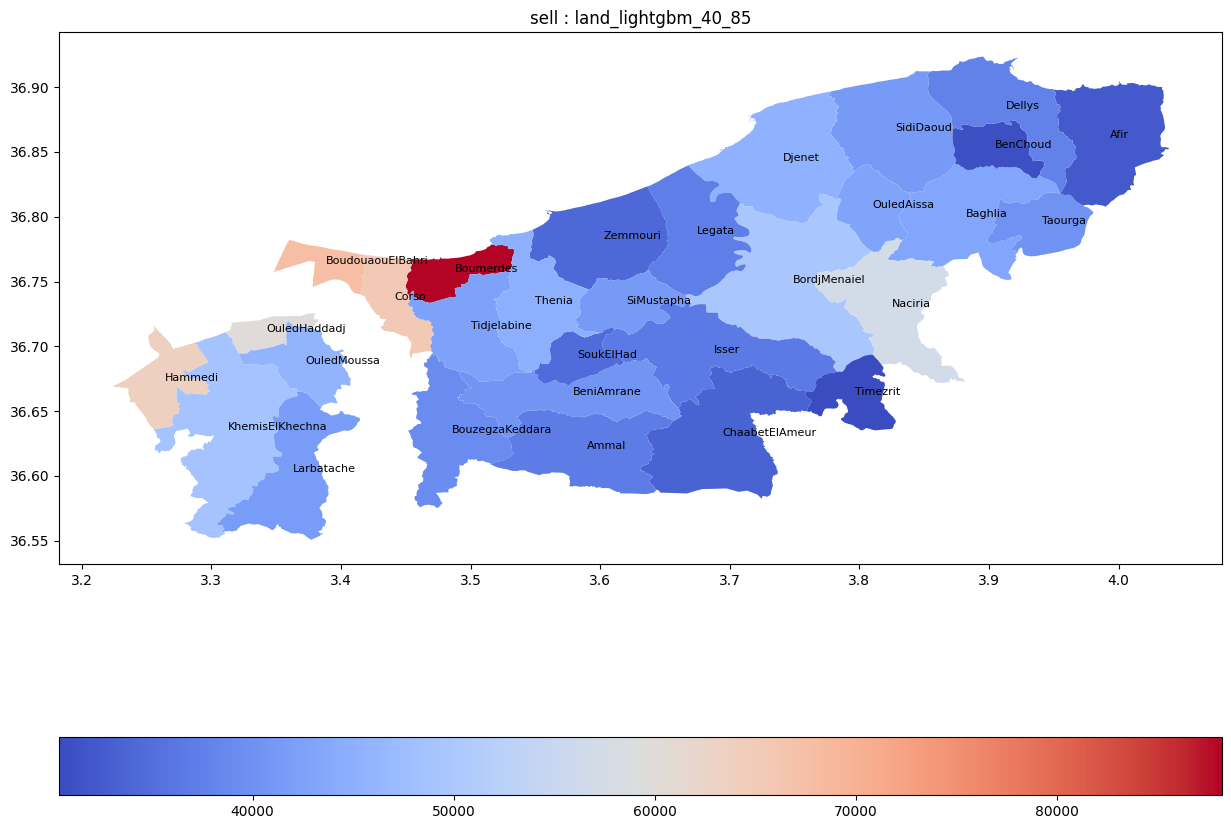

In [46]:
import pandas as pd
import numpy as np
import json
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt

# Load GeoJSON data
with open("models/Cities/Boumerdes.json", "r") as file:
    geojson_data = json.load(file)
features = [{'type': 'Feature', 'properties': {'name': name}, 'geometry': data} 
            for name, data in geojson_data.items()]
gdf = gpd.GeoDataFrame.from_features(features)

# Generate random points within a given polygon
def generate_random_points_within_polygon(polygon, num_points):
    minx, miny, maxx, maxy = polygon.bounds
    points = []
    while len(points) < num_points:
        random_point = Point(np.random.uniform(minx, maxx), np.random.uniform(miny, maxy))
        if random_point.within(polygon):
            points.append(random_point)
    return points

# Generate predictions and compute means for each province
province_means = {}
for _, row in gdf.iterrows():
    province_name = row['name']
    province_geometry = row['geometry']
    random_points = generate_random_points_within_polygon(province_geometry, 3000)
    coords = np.array([(point.y, point.x) for point in random_points])
    predictions = lgbm_model_2.predict(coords)
    province_means[province_name] = predictions.mean()

# Add mean predictions to GeoDataFrame
gdf['mean_prediction'] = gdf['name'].map(province_means)

# Plot the map with province names and mean predictions
fig, ax = plt.subplots(figsize=(15, 15))

gdf.plot(column='mean_prediction', cmap='coolwarm', legend=True, ax=ax,  legend_kwds={'orientation': 'horizontal'})
# Add province names as labels
for _, row in gdf.iterrows():
    ax.text(row['geometry'].centroid.x, row['geometry'].centroid.y, row['name'], fontsize=8)
ax.set_title('sell : land_lightgbm_40_85')
plt.show()